In [12]:
import os
import numpy as np
import tensorflow.keras.preprocessing.image as img_preproc
import matplotlib.pyplot as plt

#Files should be placed inside the directories below
input_dir = "images/train/"
target_dir = "annotations/train/"
img_size = (160, 160)
num_classes = 2
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    
assert len(input_img_paths)>0,"input_dir is empty"
assert len(input_img_paths)>0,"target_dir is empty"

Number of samples: 900
images/train/ISIC_0000000.jpg | annotations/train/ISIC_0000000_Segmentation.png
images/train/ISIC_0000001.jpg | annotations/train/ISIC_0000001_Segmentation.png
images/train/ISIC_0000002.jpg | annotations/train/ISIC_0000002_Segmentation.png
images/train/ISIC_0000004.jpg | annotations/train/ISIC_0000004_Segmentation.png
images/train/ISIC_0000006.jpg | annotations/train/ISIC_0000006_Segmentation.png
images/train/ISIC_0000007.jpg | annotations/train/ISIC_0000007_Segmentation.png
images/train/ISIC_0000008.jpg | annotations/train/ISIC_0000008_Segmentation.png
images/train/ISIC_0000009.jpg | annotations/train/ISIC_0000009_Segmentation.png
images/train/ISIC_0000010.jpg | annotations/train/ISIC_0000010_Segmentation.png
images/train/ISIC_0000011.jpg | annotations/train/ISIC_0000011_Segmentation.png


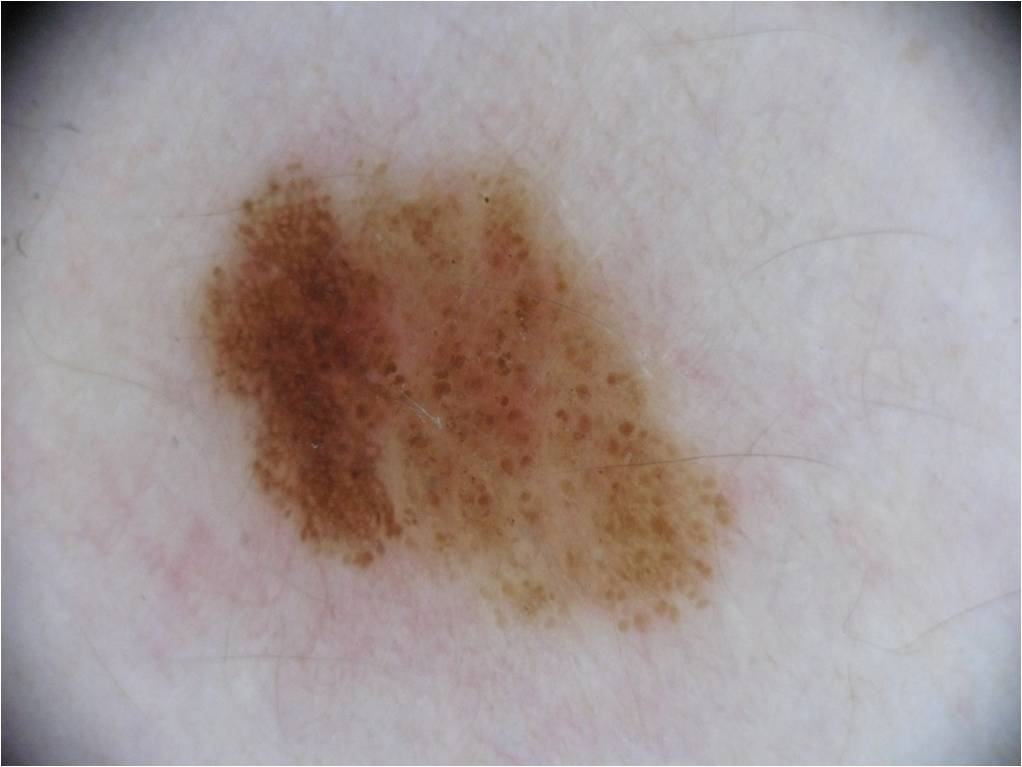

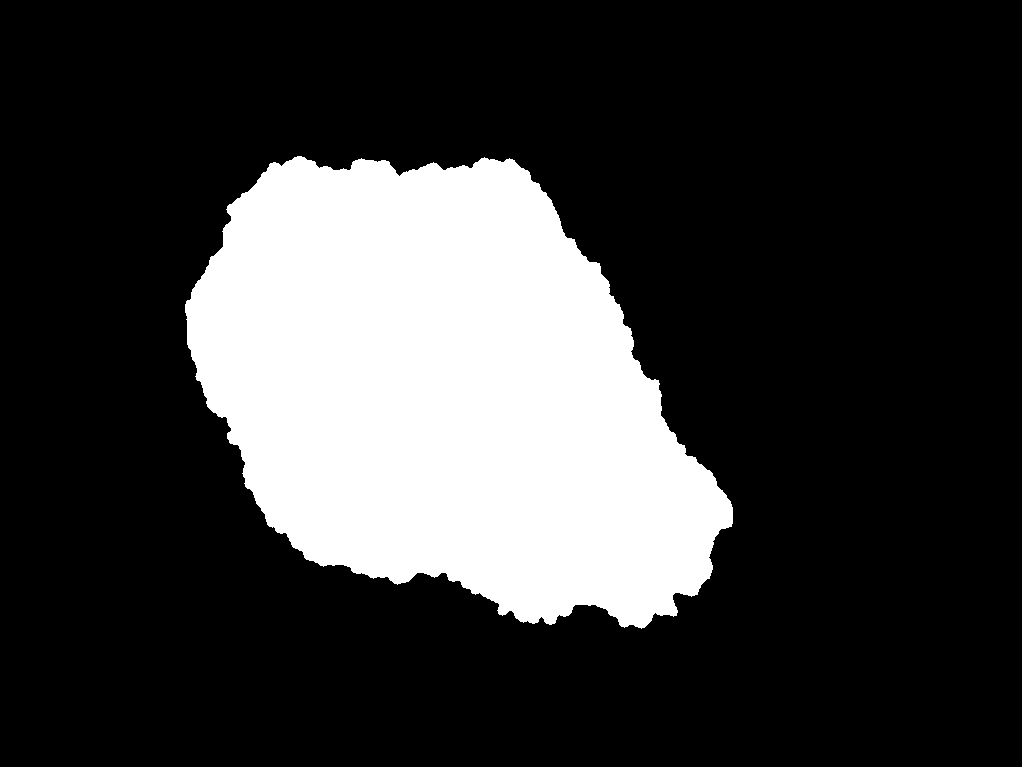

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = load_img(target_img_paths[7],color_mode="grayscale")
display(img)

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-11-02 21:40:57.077030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 21:40:57.096431: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1896300000 Hz
2022-11-02 21:40:57.097296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3d9dd90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-02 21:40:57.097315: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
import random
from dataset import ISICChallenge

# Split our img paths into a training and a validation set
val_samples = 150
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = ISICChallenge(
    batch_size, img_size, train_input_img_paths, train_target_img_paths, shuffle=True, augment=True
)
val_gen = ISICChallenge(
    batch_size, img_size, val_input_img_paths, val_target_img_paths, shuffle=False, augment=False
)

In [6]:
def jaccard(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall

metrics = ['accuracy', jaccard]

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=metrics)

In [8]:
callbacks = [
    ModelCheckpoint("isic-challenge_segmentation_augmentation.h5", save_best_only=True),
    EarlyStopping(min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
history = model.fit(train_gen, 
                    epochs=epochs, 
                    validation_data=val_gen, 
                    callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - 50s 2s/step - loss: 2.0271 - accuracy: 0.7670 - jaccard: 0.2776 - val_loss: 2.3786 - val_accuracy: 0.9321 - val_jaccard: 0.2714
Epoch 2/50
23/23 [==============================] - 51s 2s/step - loss: 0.7767 - accuracy: 0.7617 - jaccard: 0.2771 - val_loss: 0.5099 - val_accuracy: 0.9099 - val_jaccard: 0.2714
Epoch 3/50
23/23 [==============================] - 48s 2s/step - loss: 0.5653 - accuracy: 0.7494 - jaccard: 0.2778 - val_loss: 0.5430 - val_accuracy: 0.9650 - val_jaccard: 0.2714
Epoch 4/50
23/23 [==============================] - 49s 2s/step - loss: 0.4957 - accuracy: 0.7722 - jaccard: 0.2771 - val_loss: 0.6256 - val_accuracy: 0.7808 - val_jaccard: 0.2714
Epoch 5/50
23/23 [==============================] - 48s 2s/step - loss: 0.5049 - accuracy: 0.7593 - jaccard: 0.2846 - val_loss: 0.5367 - val_accuracy: 0.9693 - val_jaccard: 0.2714
Epoch 6/50
23/23 [==============================] - 49s 2s/step - loss: 0.4650 - accuracy: 0.7782 - 

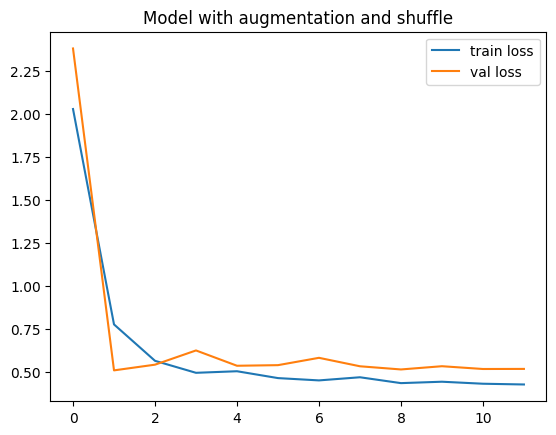

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc="upper right")
plt.title("Model with augmentation and shuffle")
plt.show()

In [9]:
val_gen = ISICChallenge(batch_size, img_size, val_input_img_paths, val_target_img_paths, shuffle=False, augment=False)
val_preds = model.predict(val_gen)

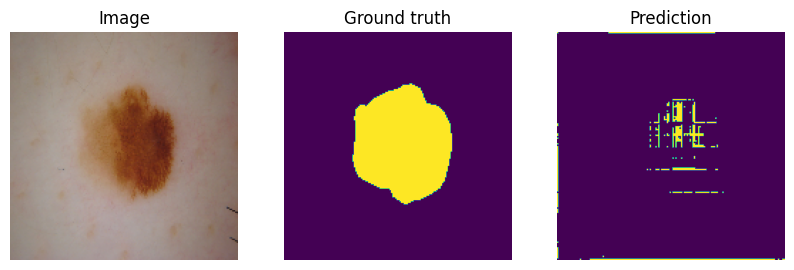

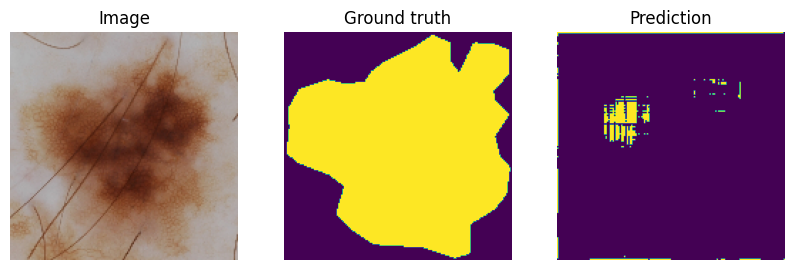

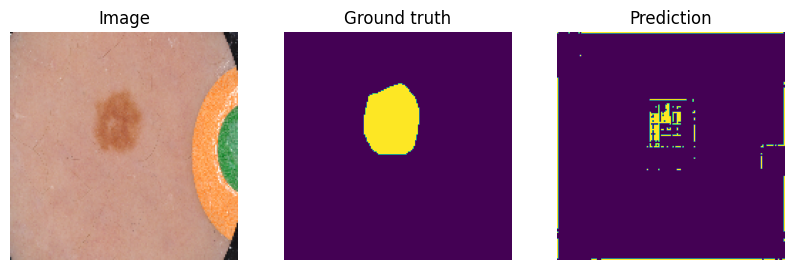

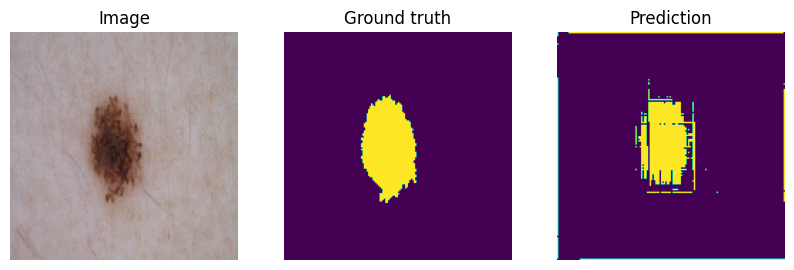

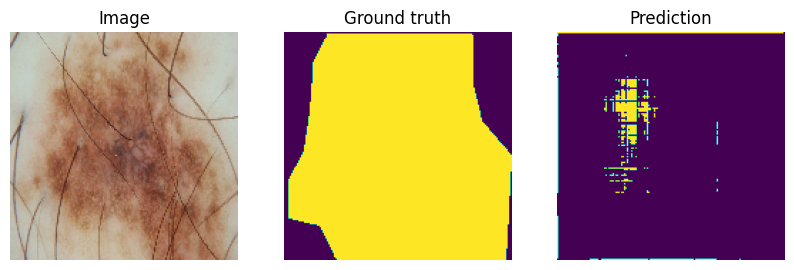

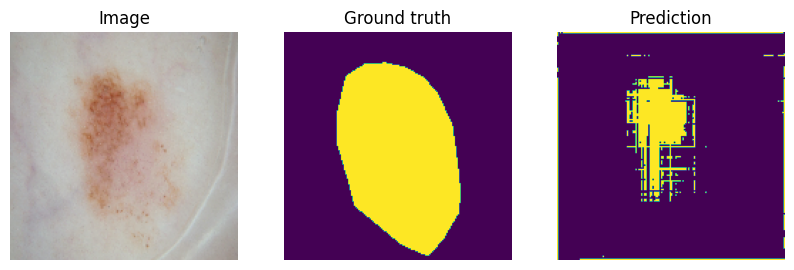

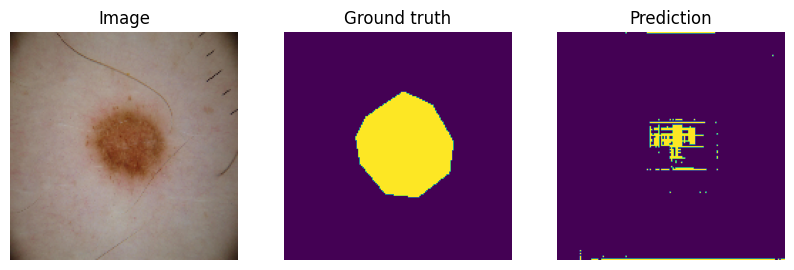

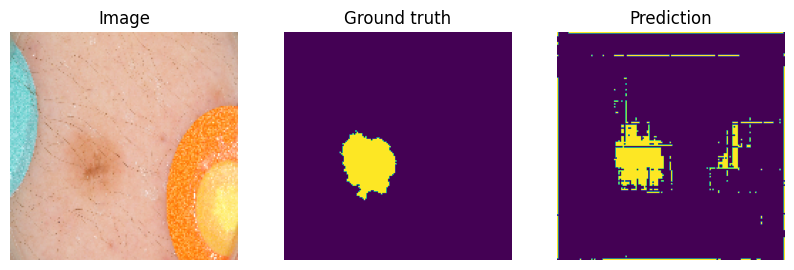

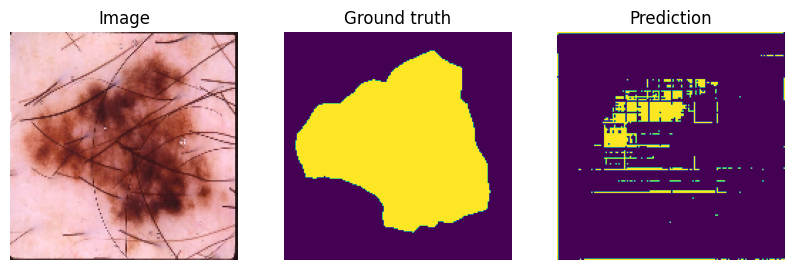

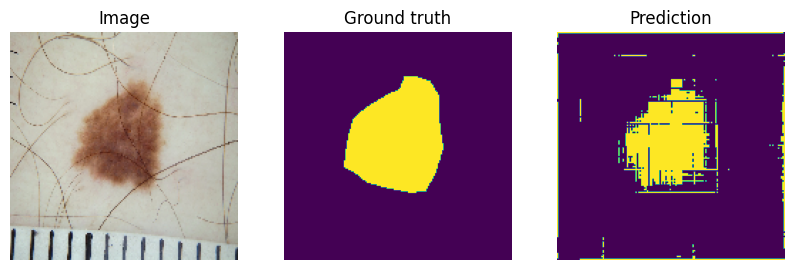

In [13]:
max_img = 10
pr_masks = np.argmax(val_preds, axis=-1)
    
for img_path, mask_path, pr_mask in zip(val_input_img_paths[:max_img], 
                                        val_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

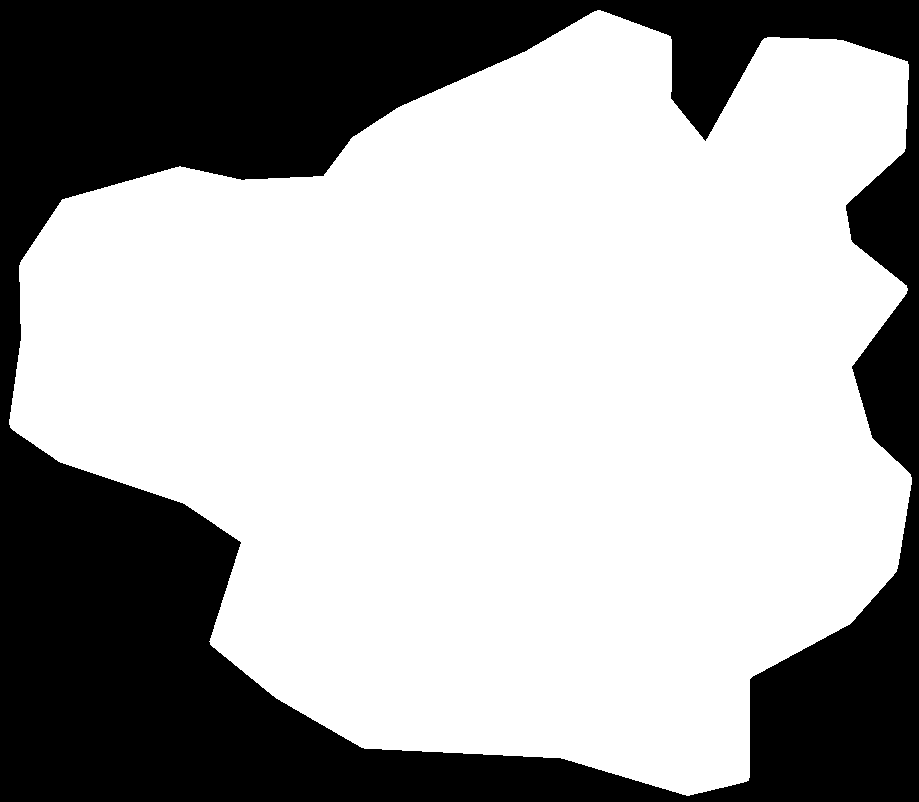

In [28]:
img = load_img(val_target_img_paths[1])
img

In [13]:
val_preds[0][0][0]

array([0.643452  , 0.35654804], dtype=float32)

In [14]:
np.argmax(val_preds[0][10:20,10:20], axis=-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [15]:
np.argmax(val_preds[0][50:60,50:60], axis=-1)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

(160, 160)


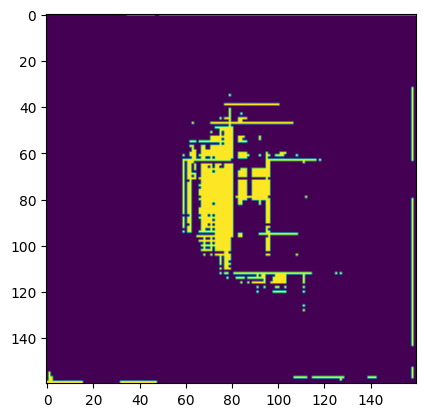

In [16]:
mask = np.argmax(val_preds[0], axis=-1)
print(mask.shape)
plt.imshow(mask)

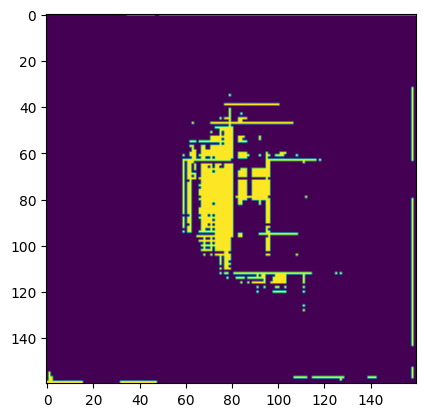

In [17]:
mask = np.expand_dims(mask, axis=-1)
plt.imshow(mask)

# Model evaluation - Test set

In [26]:
from segmentation_metrics import calculate_metrics

input_dir = "images/test/"
target_dir = "annotations/test/"
img_size = (160, 160)
num_classes = 2
batch_size = 16

test_input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(test_input_img_paths))

Number of samples: 379


In [21]:
test_gen = ISICChallenge(
    1, img_size, test_input_img_paths, test_target_img_paths, shuffle=False, augment=False
)

In [22]:
test_preds = model.predict(test_gen)

In [23]:
y = np.zeros((len(test_input_img_paths),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(test_target_img_paths):
    mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [24]:
y = np.squeeze(y)
pr_masks = np.argmax(test_preds, axis=-1)
y.shape, pr_masks.shape

((379, 160, 160), (379, 160, 160))

In [25]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

Specificity: 0.9604764580726624
Sensitivity(Recall): 0.21293677389621735
Jaccard score: 0.1934583118106156
Dice coefficient: 0.324
Accuracy: 0.7497525215148926


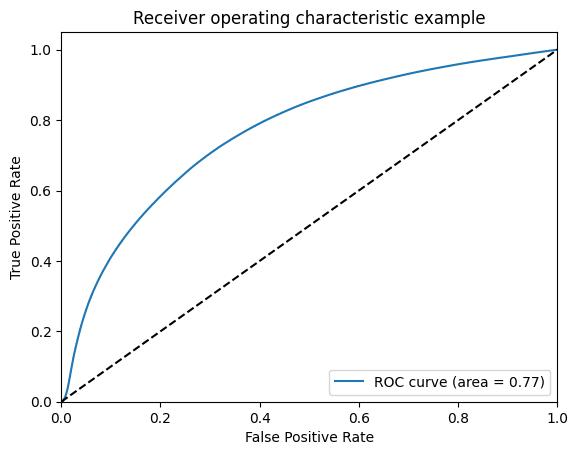

In [27]:
calculate_metrics(y, test_preds)

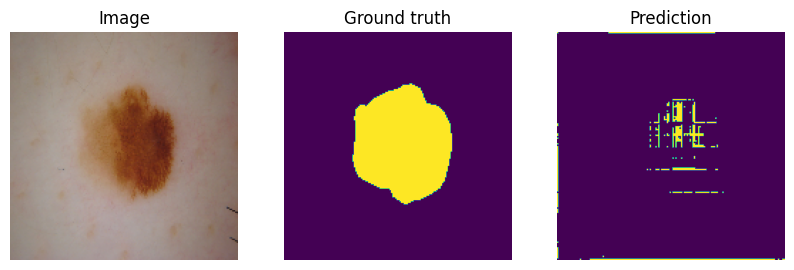

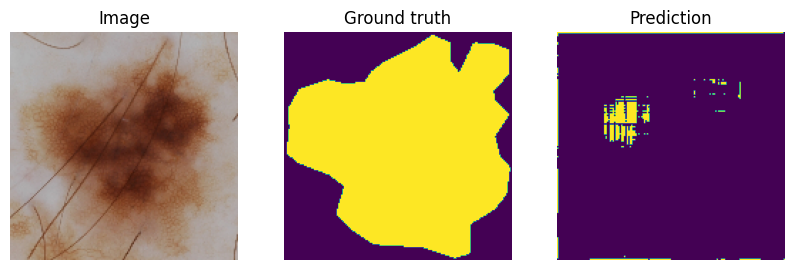

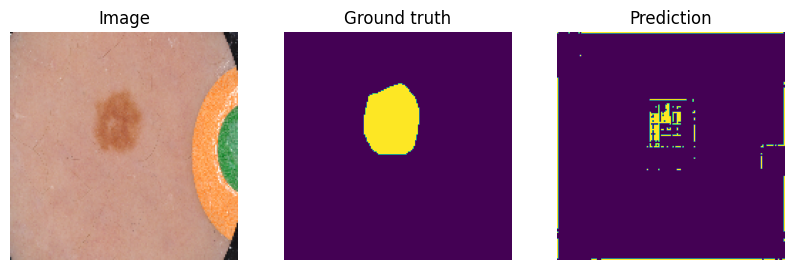

In [34]:
max_img = 3
pr_masks = np.argmax(val_preds, axis=-1)
    
for img_path, mask_path, pr_mask in zip(val_input_img_paths[:max_img], 
                                        val_target_img_paths[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(img_path, target_size=img_size)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()